In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
# Import các lớp cần thiết từ thư viện Surprise cho cell 8
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split

# Thiết lập cho biểu đồ (tùy chọn)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [5]:
# Tải các biến từ file .env
load_dotenv()

# Lấy chuỗi kết nối từ biến môi trường
DATABASE_URL = os.getenv('DATABASE_URL')

if not DATABASE_URL:
    raise ValueError("DATABASE_URL not found in .env file. Please check your configuration.")

# Tạo một "engine" kết nối đến database bằng SQLAlchemy
# SQLAlchemy là một ORM mạnh mẽ cho Python, nhưng ở đây ta chỉ dùng nó để kết nối
try:
    engine = create_engine(DATABASE_URL)
    print("Database engine created successfully.")
except Exception as e:
    print(f"Failed to create database engine: {e}")

Database engine created successfully.


In [9]:
# Câu lệnh SQL để lấy các cột cần thiết từ bảng Rating
query = """
SELECT 
    "userId", 
    "movieId", 
    score 
FROM "Rating";
"""

# Sử dụng Pandas để đọc dữ liệu trực tiếp từ database
# Quá trình này có thể mất 10-20 giây
print("Loading ratings data from database...")
try:
    ratings_df = pd.read_sql(query, engine)
    print("Data loaded successfully!")
    
    # Hiển thị 5 dòng đầu tiên để kiểm tra
    display(ratings_df.head())
    
    # Hiển thị thông tin tổng quan về DataFrame
    print("\nDataFrame Info:")
    ratings_df.info()

except Exception as e:
    print(f"Failed to load data: {e}")

Loading ratings data from database...
Data loaded successfully!


,userId,movieId,score
0,fef77507-5d6c-4ed1-9843-a2e699906acb,862,4
1,fef77507-5d6c-4ed1-9843-a2e699906acb,15602,4
2,fef77507-5d6c-4ed1-9843-a2e699906acb,949,4
3,fef77507-5d6c-4ed1-9843-a2e699906acb,807,5
4,fef77507-5d6c-4ed1-9843-a2e699906acb,629,5



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100806 entries, 0 to 100805
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   userId   100806 non-null  object
 1   movieId  100806 non-null  int64 
 2   score    100806 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


In [10]:
print("Basic Descriptive Statistics for Ratings:")
print("ratings_df exists:", 'ratings_df' in globals())
display(ratings_df['score'].describe())

print(f"\nTotal number of unique users: {ratings_df['userId'].nunique()}")
print(f"Total number of unique movies: {ratings_df['movieId'].nunique()}")

# Tính độ thưa (sparsity) của ma trận
n_users = ratings_df['userId'].nunique()
n_movies = ratings_df['movieId'].nunique()
n_ratings = len(ratings_df)
sparsity = 1 - (n_ratings / (n_users * n_movies))
print(f"Sparsity of the user-item matrix: {sparsity:.2%}")

Basic Descriptive Statistics for Ratings:
ratings_df exists: True


count    100806.000000
mean          3.652233
std           1.045132
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: score, dtype: float64


Total number of unique users: 611
Total number of unique movies: 9707
Sparsity of the user-item matrix: 98.30%


C:\Users\Admin\AppData\Local\Temp\ipykernel_84732\671684547.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='score', data=ratings_df, palette='viridis')


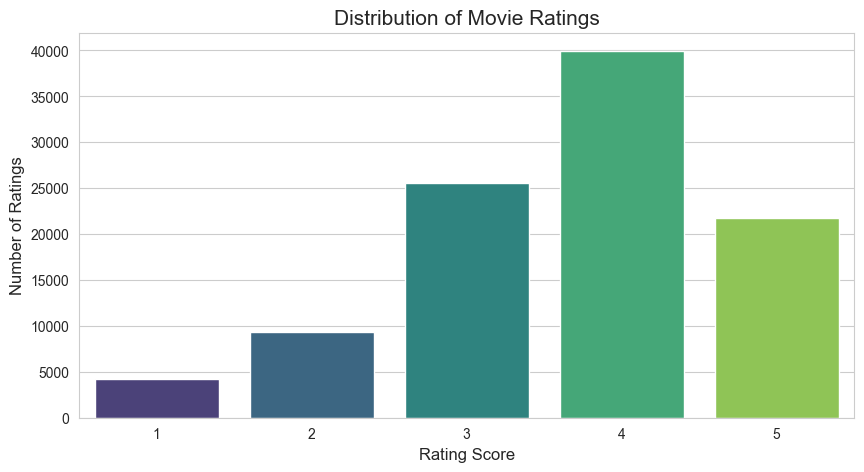

In [11]:
plt.figure(figsize=(10, 5))
sns.countplot(x='score', data=ratings_df, palette='viridis')
plt.title('Distribution of Movie Ratings', fontsize=15)
plt.xlabel('Rating Score', fontsize=12)
plt.ylabel('Number of Ratings', fontsize=12)
plt.show()

Thấy rằng điểm 4 thường là cột cao nhất, tiếp theo là 3 và 5. Điểm 1 và 2 ít hơn. Điều này cho thấy người dùng có xu hướng đánh giá những phim họ thích.

Loading movies data from database...

Top 10 Most Rated Movies:


title
Forrest Gump                  329
Shawshank Redemption, The     317
Pulp Fiction                  307
Silence of the Lambs, The     279
Matrix, The                   278
Star Wars                     251
Jurassic Park                 238
Braveheart                    237
Terminator 2: Judgment Day    224
Schindler's List              220
Name: count, dtype: int64

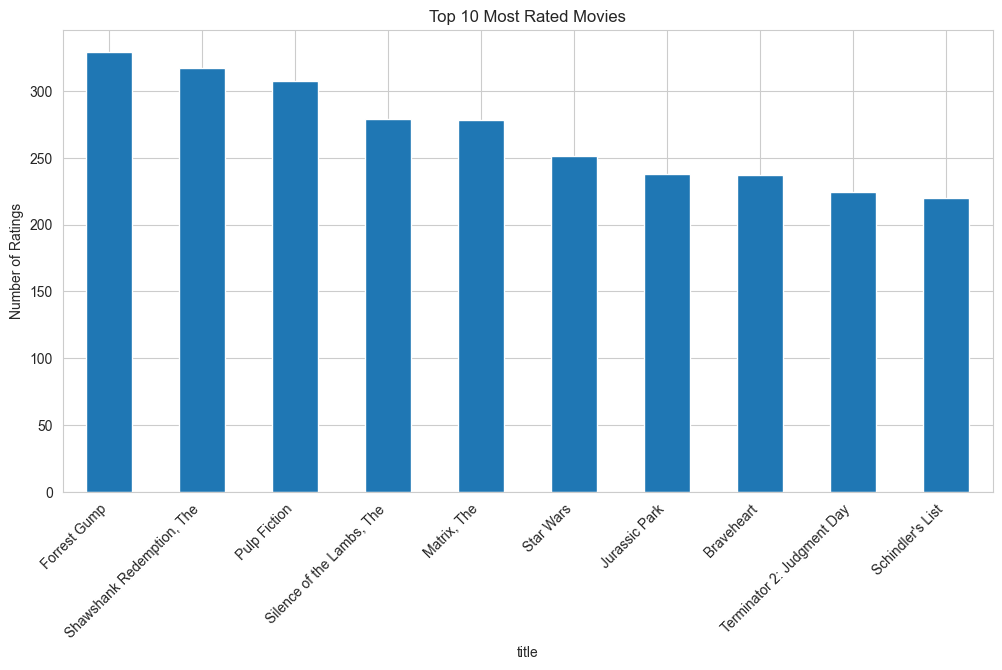

In [12]:
# Để hiển thị tên phim, chúng ta cần tải thêm bảng `Movie`
print("Loading movies data from database...")
movies_df = pd.read_sql('SELECT id, title FROM "Movie";', engine)

# Gộp (merge) hai DataFrame lại với nhau
movie_ratings_df = pd.merge(ratings_df, movies_df, left_on='movieId', right_on='id')

# Đếm số lần xuất hiện của mỗi phim
movie_rating_counts = movie_ratings_df['title'].value_counts()

print("\nTop 10 Most Rated Movies:")
display(movie_rating_counts.head(10))

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
movie_rating_counts.head(10).plot(kind='bar')
plt.title('Top 10 Most Rated Movies')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45, ha='right')
plt.show()


Statistics for number of ratings per user:


count     611.000000
mean      164.985270
std       269.250097
min         1.000000
25%        35.000000
50%        70.000000
75%       168.000000
max      2698.000000
Name: count, dtype: float64

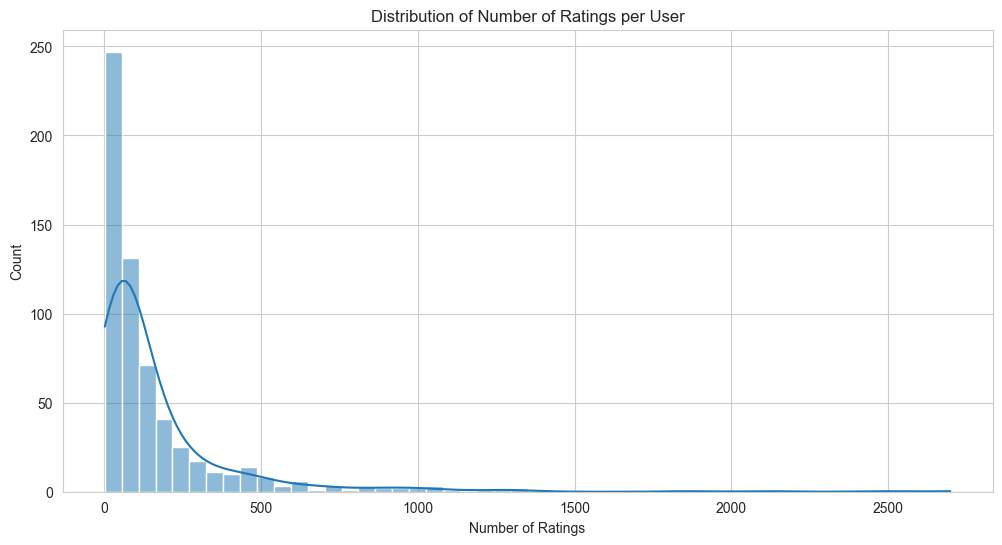

In [13]:
user_rating_counts = ratings_df['userId'].value_counts()

print("\nStatistics for number of ratings per user:")
display(user_rating_counts.describe())

# Vẽ biểu đồ phân phối
plt.figure(figsize=(12, 6))
sns.histplot(user_rating_counts, bins=50, kde=True)
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.show()

Thấy rằng hầu hết người dùng chỉ đánh giá một số lượng nhỏ phim, trong khi có một vài "super user" đánh giá rất nhiều. Đây là một đặc điểm phổ biến của các hệ thống gợi ý.


Người có ít đánh giá sẽ khó dự đoán (cold start).

Người có nhiều đánh giá có thể ảnh hưởng mạnh đến mô hình.

In [14]:


# Bước 1: Định nghĩa "Người đọc" (Reader)
# Chúng ta cần nói cho Surprise biết thang điểm đánh giá của chúng ta là từ 1 đến 5.
reader = Reader(rating_scale=(1, 5))

# Bước 2: Tải dữ liệu từ DataFrame vào Dataset của Surprise
# Surprise chỉ cần 3 cột theo đúng thứ tự: user, item, rating.
# Chúng ta sẽ dùng DataFrame `ratings_df` đã tải ở bước đầu.
print("Loading data into Surprise's Dataset format...")
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'score']], reader)
print("Data loaded successfully.")

Loading data into Surprise's Dataset format...
Data loaded successfully.


In [20]:
# Chia dữ liệu theo tỉ lệ 80% cho huấn luyện/validation và 20% cho kiểm thử.
# `random_state` đảm bảo rằng mỗi lần bạn chạy lại code, kết quả chia đều giống hệt nhau.
trainval_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

print(f"Total number of ratings: {len(ratings_df)}")
# Để lấy số lượng ratings trong một set của Surprise, ta dùng .all_ratings()
print(f"Number of ratings in Train/Validation set (80%): {len(list(trainval_set.all_ratings()))}")
print(f"Number of ratings in Test set (20%): {len(test_set)}")

Total number of ratings: 100806
Number of ratings in Train/Validation set (80%): 80644
Number of ratings in Test set (20%): 20162
